# Importing Libraries

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, SequentialSampler, BatchSampler
import torchvision
from torchvision import transforms

!pip install pytorch_metric_learning
from pytorch_metric_learning import losses, samplers
from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method
from umap import UMAP
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

from timeit import default_timer as timer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from PIL import Image
import random
import cv2
import glob
import os

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 3.9 MB/s eta 0:00:00


---
# Functions 

### Cifar10 Dataset:

In [2]:
class Cifar10Dataset(Dataset):
    
    def __init__(self, imgs_list, classes, transforms):
        super(Cifar10Dataset, self).__init__()
        
        self.imgs_list = imgs_list
        self.class_to_int = {classes[i] : i for i in range(len(classes))}
        self.transforms = transforms
        
        
    def __getitem__(self, index):

        # Image path
        image_path = self.imgs_list[index]
        
        # Reading image
        image = Image.open(image_path)
        
        # Retriving class label
        label = image_path.split("/")[-2]
        label = self.class_to_int[label]
        
        # Applying transforms on image
        image = self.transforms(image)
        
        return image, label
        

    def __len__(self):
        return len(self.imgs_list)

### Batch Sampler:

In [3]:
class BalancedBatchSampler(BatchSampler):
    # Adopted from https://discuss.pytorch.org/t/load-the-same-number-of-data-per-class/
    """
    BatchSampler - from a MNIST-like dataset, samples n_classes and within these classes samples n_samples.
    Returns batches of size n_classes * n_samples
    """

    def __init__(self, dataset, n_classes, n_samples):
        loader = DataLoader(dataset)
        self.labels_list = []
        for _, label in loader:
            self.labels_list.append(label)
        self.labels = torch.LongTensor(self.labels_list)
        self.labels_set = list(set(self.labels.numpy()))
        self.label_to_indices = {label: np.where(self.labels.numpy() == label)[0]
                                 for label in self.labels_set}
        for l in self.labels_set:
            np.random.shuffle(self.label_to_indices[l])
        self.used_label_indices_count = {label: 0 for label in self.labels_set}
        self.count = 0
        self.n_classes = n_classes
        self.n_samples = n_samples
        self.dataset = dataset
        self.batch_size = self.n_samples * self.n_classes

    def __iter__(self):
        self.count = 0
        while self.count + self.batch_size <= len(self.dataset):
            classes = np.random.choice(self.labels_set, self.n_classes, replace=False)
            indices = []
            for class_ in classes:
                indices.extend(self.label_to_indices[class_][
                               self.used_label_indices_count[class_]:self.used_label_indices_count[
                                                                         class_] + self.n_samples])
                self.used_label_indices_count[class_] += self.n_samples
                if self.used_label_indices_count[class_] + self.n_samples > len(self.label_to_indices[class_]):
                    np.random.shuffle(self.label_to_indices[class_])
                    self.used_label_indices_count[class_] = 0
            
            random.shuffle(indices)
            yield indices
            self.count += self.n_classes * self.n_samples

    def __len__(self):
        return len(self.dataset) // self.batch_size

### Sample Images Plotting:

In [4]:
def sample_images(dataloader, title):
    # Check out what's inside the training dataloader
    train_features_batch, train_labels_batch = next(iter(dataloader))

    plt.figure(figsize=(6, 5))
    nrows = 5
    ncols = 6
    for i in range(30):
        plt.subplot(nrows, ncols, i+1)
        img, label = train_features_batch[i], train_labels_batch[i]
        mean, std = 0.5, 0.5
        img = std * img + mean
        plt.imshow(img.permute(1, 2, 0))
        plt.title(classes[label], fontsize=7, pad=0)
        plt.axis("Off")

    plt.suptitle(title, fontsize=20, )
    plt.tight_layout(pad=0.5)

### Accuracy Calculator Function:

In [5]:
def accuracy_fn(true, pred):
    pred = F.softmax(pred, dim = 1)
    true = torch.zeros(pred.shape[0], pred.shape[1]).scatter_(1, true.unsqueeze(1), 1.)
    acc = (true.argmax(-1) == pred.argmax(-1)).float().detach().numpy()
    acc = float((100 * acc.sum()) / len(acc))
    return round(acc, 4)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Train Step:

In [6]:
def train_step(model,
               data_loader,
               loss_fn,
               optimizer,
               fg_attack=False,
               accuracy_fn=accuracy_fn,
               device=device):
    
    # Send model to GPU
    model.to(device)
    train_loss, train_acc, counter = 0, 0, 0
    with tqdm(data_loader, desc ="  train") as train_tqdm:
        for X, y in train_tqdm:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            if fg_attack:
                X = fast_gradient_method(model, x=X, eps=0.1, norm=np.inf)

            # 1. Forward pass
            y_pred = model(X)

            # 2. Calculate loss
            loss = loss_fn(y_pred, y)
            train_loss += loss.item()
            train_acc += accuracy_fn(true=y.cpu(),
                                     pred=y_pred.cpu())
            counter += 1
            train_tqdm.set_postfix(train_acc=train_acc/counter, train_loss=train_loss/counter, refresh=True)

            # 3. Optimizer zero grad
            optimizer.zero_grad()

            # 4. Loss backward
            loss.backward()

            # 5. Optimizer step
            optimizer.step()

        # Calculate loss and accuracy per epoch and print out what's happening
        train_loss /= len(data_loader)
        train_acc /= len(data_loader)
        
    return train_loss, train_acc


### Test Step:

In [7]:
def test_step(model,
              data_loader,
              loss_fn,
              fg_attack=False,
              accuracy_fn=accuracy_fn,
              device=device):
    
    # Send model to GPU
    model.to(device)

    # put model in eval mode
    model.eval() 
    test_loss, test_acc, counter = 0, 0, 0
    with tqdm(data_loader, desc ="   test") as test_tqdm:
        for X, y in test_tqdm:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            if fg_attack:
                X = fast_gradient_method(model, x=X, eps=0.1, norm=np.inf)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y).item()
            test_acc += accuracy_fn(true=y.cpu(),
                                    pred=test_pred.cpu())
            counter += 1
            test_tqdm.set_postfix(test_acc=test_acc/counter, test_loss=test_loss/counter, refresh=True)

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc  /= len(data_loader)
            
    return test_loss, test_acc

### Train Function:

In [8]:
def Train(train_dataloader, test_dataloader, model, loss_fn, optimizer, scheduler, epochs, fg_attack=False):
    
    train_epoch_loss = []
    train_epoch_accuracy = []
    test_epoch_loss = []
    test_epoch_accuracy = []

    train_time_start = timer()

    for epoch in range(epochs):
        print("EPOCH {}/{} :".format(epoch +1, epochs))
        train_loss, train_acc = train_step(data_loader=train_dataloader,
                                           model=model, 
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           fg_attack=fg_attack,
                                           )
        test_loss, test_acc = test_step(data_loader=test_dataloader,
                                        model=model,
                                        loss_fn=loss_fn,
                                        fg_attack=fg_attack,
                                        )
        # decreasing the LR with scheduler
        scheduler.step()

        train_epoch_loss.append(train_loss)
        train_epoch_accuracy.append(train_acc)
        test_epoch_loss.append(test_loss)
        test_epoch_accuracy.append(test_acc)

    train_time_end = timer()
    total_time = train_time_end - train_time_start
    print(f"\n\nTrain time: {total_time:.3f} seconds")
    
    return train_epoch_loss, train_epoch_accuracy, test_epoch_loss, test_epoch_accuracy

### UMAP Dimension Reduction:

In [9]:
def UMAP_DR(model,
            train_data_loader,
            test_data_loader,
            fg_attack=False,
            title="UMAP",
            device=device):
    
    model.to(device)
    train_data = torch.tensor([]).to(device)
    test_data = torch.tensor([]).to(device)

    model.eval() 
    with tqdm(train_data_loader, desc ="  train") as test_tqdm:
        for X, y in test_tqdm:

            X, y = X.to(device), y.to(device)

            if fg_attack:
                X = fast_gradient_method(model, x=X, eps=0.1, norm=np.inf)

            backbone_output = model(X).detach().squeeze()

            data_with_label = torch.concat([backbone_output, y.unsqueeze(1)], 1)
            train_data = torch.concat([train_data, data_with_label], 0)
            
    with tqdm(test_data_loader, desc ="   test") as test_tqdm:
        for X, y in test_tqdm:

            X, y = X.to(device), y.to(device)

            if fg_attack:
                X = fast_gradient_method(model, x=X, eps=0.1, norm=np.inf)

            backbone_output = model(X).detach().squeeze()

            data_with_label = torch.concat([backbone_output, y.unsqueeze(1)], 1)
            test_data = torch.concat([test_data, data_with_label], 0)
            
    model = UMAP(random_state=0)
    model.fit(train_data[:,:-1].cpu())
    reduced_X = model.transform(test_data[:,:-1].cpu())
    Y = test_data[:,-1].cpu()
    
    plt.figure(figsize=(9,7))
    sns.scatterplot(x=reduced_X[:,0], y=reduced_X[:,1], hue=Y, palette='tab10', size=1)
    plt.title(title, fontsize=15);
    
    return reduced_X, Y

### Add Random Noise to Pictures:

In [10]:
class RandomPixelNoise(object):
    # Adopted from ChatGPT
    def __init__(self, num_pixels, noise_std=0.1):
        self.num_pixels = num_pixels
        self.noise_std = noise_std

    def __call__(self, img_tensor):
        # Get the height and width of the image
        height, width = img_tensor.size(1), img_tensor.size(2)

        # Choose a random set of pixels to perturb
        pixels = np.random.choice(height * width, self.num_pixels, replace=False)

        # Create a mask tensor with the same size as the input tensor, where the selected pixels are set to 1
        mask_tensor = torch.zeros(height * width)
        mask_tensor[pixels] = 1
        mask_tensor = mask_tensor.view(1, height, width)

        # Create a noise tensor with the same size as the input tensor
        noise_tensor = torch.randn(1, height, width) * self.noise_std

        # Multiply the noise tensor by the mask tensor to only add noise to the selected pixels
        perturbed_tensor = img_tensor + noise_tensor * mask_tensor

        # Clamp the pixel values of the perturbed tensor to lie within [0, 1]
        perturbed_tensor = torch.clamp(perturbed_tensor, 0, 1)

        return perturbed_tensor

### Loss & Accuracy Plots:

In [11]:
def accloss_plots(train_loss, test_loss, train_acc, test_acc, title):
  
    num_epochs = len(train_loss)
    plt.figure(figsize=(13,5))
    plt.subplot(121)
    plt.plot(train_loss, 'r', label='Train')
    plt.plot(test_loss , 'g', label='Test')
    plt.xlabel('Epochs', fontsize=10, labelpad=8)
    plt.title('Loss', fontsize=20, pad=15)
    plt.grid()
    plt.legend()
    sns.despine()
    plt.subplot(122)
    plt.plot(train_acc, 'r', label='Train')
    plt.plot(test_acc, 'g', label='Test')
    plt.xlabel('Epochs', fontsize=10, labelpad=8)
    plt.title('Accuracy', fontsize=20, pad=15)
    plt.tight_layout(pad=3)
    plt.grid()
    plt.legend()
    plt.suptitle(title, fontsize=25)
    sns.despine()
    plt.show();

### Calculating Classifier Accuracy on AngularLoss Using KNN:

In [12]:
def accuracy_calc_using_KNN(model,
                            train_data_loader,
                            test_data_loader,
                            fg_attack=False,
                            device=device):
    
    # Send model to GPU
    model.to(device)
    train_data = torch.tensor([]).to(device)
    test_data = torch.tensor([]).to(device)
    # put model in eval mode
    model.eval() 
    with tqdm(train_data_loader, desc ="  train") as test_tqdm:
        for X, y in test_tqdm:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            if fg_attack:
                X = fast_gradient_method(model, x=X, eps=0.1, norm=np.inf)

            # Forward pass
            backbone_output = model(X).detach().squeeze()

            data_with_label = torch.concat([backbone_output, y.unsqueeze(1)], 1).cpu()
            train_data = torch.concat([train_data.cpu(), data_with_label], 0)
            
    with tqdm(test_data_loader, desc ="   test") as test_tqdm:
        for X, y in test_tqdm:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            if fg_attack:
                X = fast_gradient_method(model, x=X, eps=0.1, norm=np.inf)

            # Forward pass
            backbone_output = model(X).detach().squeeze()

            data_with_label = torch.concat([backbone_output, y.unsqueeze(1)], 1).cpu()
            test_data = torch.concat([test_data.cpu(), data_with_label], 0)
            
    k = 10
    knn_clf = KNeighborsClassifier(n_neighbors = k)
    knn_clf.fit(train_data[:,:-1], train_data[:,-1])
    y_pred = knn_clf.predict(test_data[:,:-1])
            
    return metrics.accuracy_score(test_data[:,-1], y_pred)

---
# Part 1

In [13]:
DIR_TRAIN = "/kaggle/input/cifar10/cifar10/train/"
DIR_TEST = "/kaggle/input/cifar10/cifar10/test/"

In [14]:
classes = os.listdir(DIR_TRAIN)
print(f"Total Classes: {len(classes)}\n")

percentage = 0.2
train_imgs = []
val_imgs  = []
test_imgs = []
for i, _class in enumerate(classes):
    train = glob.glob(DIR_TRAIN + _class + '/*.png')
    train_imgs += train[:int(percentage*len(train))]
    val_imgs += train[int(percentage*len(train)):]
    test = glob.glob(DIR_TEST + _class + '/*.png')
    test_imgs += test
    print(f"Class {i} Train: {len(train)}, Test: {len(test)}")


print("\nTotal train images: ", len(train_imgs))
print("Total val images: ", len(val_imgs))
print("Total test images: ", len(test_imgs))

Total Classes: 10

Class 0 Train: 5000, Test: 1000
Class 1 Train: 5000, Test: 1000
Class 2 Train: 5000, Test: 1000
Class 3 Train: 5000, Test: 1000
Class 4 Train: 5000, Test: 1000
Class 5 Train: 5000, Test: 1000
Class 6 Train: 5000, Test: 1000
Class 7 Train: 5000, Test: 1000
Class 8 Train: 5000, Test: 1000
Class 9 Train: 5000, Test: 1000

Total train images:  10000
Total val images:  40000
Total test images:  10000


---
# Part 2

### Transformations:

In [15]:
Transforms = transforms.Compose([transforms.ToTensor(),
                                 transforms.Normalize(mean=0.5, std=0.5)])

### Building Dataloaders:

In [16]:
train_dataset_untouched = Cifar10Dataset(train_imgs, classes, Transforms)
test_dataset_untouched = Cifar10Dataset(test_imgs, classes, Transforms)
val_dataset_untouched = Cifar10Dataset(val_imgs, classes, Transforms)

In [17]:
# batchsize = 512

train_dataloader_untouched = DataLoader(
    dataset = train_dataset_untouched,
    batch_sampler = BalancedBatchSampler(train_dataset_untouched, n_classes=10, n_samples=50),
    num_workers = 2,
)

test_dataloader_untouched = DataLoader(
    dataset = test_dataset_untouched,
    batch_sampler = BalancedBatchSampler(test_dataset_untouched, n_classes=10, n_samples=50),
    num_workers = 2,
)

val_dataloader_untouched = DataLoader(
    dataset = val_dataset_untouched,
    batch_sampler = BalancedBatchSampler(val_dataset_untouched, n_classes=10, n_samples=50),
    num_workers = 2,
)

### Sample Images:

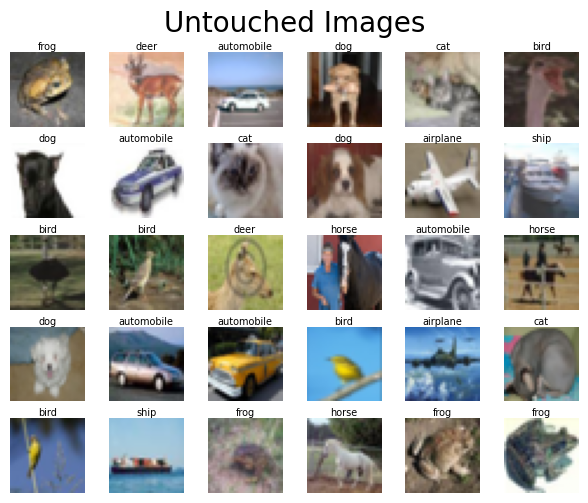

In [18]:
sample_images(dataloader=train_dataloader_untouched, title="Untouched Images")

### Defining Model (Resnet18):

In [19]:
resnet18_model_1 = torchvision.models.resnet18(weights=None)
resnet18_model_1.fc = nn.Linear(in_features=512, out_features=10, bias=True)

# Loss Function & Optimizer
CE_loss_fn = nn.CrossEntropyLoss()
optimizer_1 = torch.optim.Adam(resnet18_model_1.parameters(), lr = 0.001)
scheduler_1 = torch.optim.lr_scheduler.StepLR(optimizer_1, step_size=20, gamma=0.5)

### Training:

In [20]:
train_epoch_loss_1, train_epoch_accuracy_1, test_epoch_loss_1, test_epoch_accuracy_1 = Train(train_dataloader=train_dataloader_untouched,
                                                                                             test_dataloader=val_dataloader_untouched,
                                                                                             model=resnet18_model_1,
                                                                                             loss_fn=CE_loss_fn,
                                                                                             optimizer=optimizer_1,
                                                                                             scheduler=scheduler_1,
                                                                                             epochs=100)

EPOCH 1/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.37it/s, test_acc=22.6, test_loss=2.37]


EPOCH 2/100 :


   test: 100%|██████████| 80/80 [00:22<00:00,  3.55it/s, test_acc=26.5, test_loss=2.1] 


EPOCH 3/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.43it/s, test_acc=40.3, test_loss=1.63]


EPOCH 4/100 :


   test: 100%|██████████| 80/80 [00:22<00:00,  3.53it/s, test_acc=44.3, test_loss=1.53]


EPOCH 5/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.45it/s, test_acc=48.6, test_loss=1.44]


EPOCH 6/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.48it/s, test_acc=50.6, test_loss=1.38]


EPOCH 7/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.38it/s, test_acc=50, test_loss=1.44]  


EPOCH 8/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.41it/s, test_acc=53.1, test_loss=1.35]


EPOCH 9/100 :


   test: 100%|██████████| 80/80 [00:24<00:00,  3.26it/s, test_acc=52.2, test_loss=1.45]


EPOCH 10/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.34it/s, test_acc=54.5, test_loss=1.4] 


EPOCH 11/100 :


   test: 100%|██████████| 80/80 [00:24<00:00,  3.30it/s, test_acc=54.1, test_loss=1.46]


EPOCH 12/100 :


   test: 100%|██████████| 80/80 [00:22<00:00,  3.50it/s, test_acc=52, test_loss=1.59]  


EPOCH 13/100 :


   test: 100%|██████████| 80/80 [00:22<00:00,  3.49it/s, test_acc=53.3, test_loss=1.72]


EPOCH 14/100 :


   test: 100%|██████████| 80/80 [00:22<00:00,  3.55it/s, test_acc=53.9, test_loss=1.89]


EPOCH 15/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.44it/s, test_acc=51.2, test_loss=2.11]


EPOCH 16/100 :


   test: 100%|██████████| 80/80 [00:22<00:00,  3.52it/s, test_acc=53.9, test_loss=1.9] 


EPOCH 17/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.40it/s, test_acc=55.6, test_loss=2.12]


EPOCH 18/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.46it/s, test_acc=53.1, test_loss=2.05]


EPOCH 19/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.45it/s, test_acc=55.5, test_loss=2.15]


EPOCH 20/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.46it/s, test_acc=55, test_loss=2.48]  


EPOCH 21/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.44it/s, test_acc=56.3, test_loss=2.43]


EPOCH 22/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.46it/s, test_acc=56.6, test_loss=2.59]


EPOCH 23/100 :


   test: 100%|██████████| 80/80 [00:22<00:00,  3.48it/s, test_acc=56.8, test_loss=2.71]


EPOCH 24/100 :


   test: 100%|██████████| 80/80 [00:22<00:00,  3.51it/s, test_acc=57.2, test_loss=2.75]


EPOCH 25/100 :


   test: 100%|██████████| 80/80 [00:22<00:00,  3.51it/s, test_acc=57.3, test_loss=2.79]


EPOCH 26/100 :


   test: 100%|██████████| 80/80 [00:22<00:00,  3.48it/s, test_acc=57.4, test_loss=2.83]


EPOCH 27/100 :


   test: 100%|██████████| 80/80 [00:22<00:00,  3.51it/s, test_acc=57.4, test_loss=2.86]


EPOCH 28/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.45it/s, test_acc=57.5, test_loss=2.88]


EPOCH 29/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.43it/s, test_acc=57.5, test_loss=2.9] 


EPOCH 30/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.43it/s, test_acc=57.5, test_loss=2.92]


EPOCH 31/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.38it/s, test_acc=57.5, test_loss=2.94]


EPOCH 32/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.36it/s, test_acc=57.5, test_loss=2.96]


EPOCH 33/100 :


   test: 100%|██████████| 80/80 [00:25<00:00,  3.11it/s, test_acc=57.5, test_loss=2.97]


EPOCH 34/100 :


   test: 100%|██████████| 80/80 [00:26<00:00,  3.04it/s, test_acc=57.5, test_loss=2.99]


EPOCH 35/100 :


   test: 100%|██████████| 80/80 [00:26<00:00,  3.04it/s, test_acc=57.5, test_loss=3]   


EPOCH 36/100 :


   test: 100%|██████████| 80/80 [00:26<00:00,  3.06it/s, test_acc=57.5, test_loss=3.02]


EPOCH 37/100 :


   test: 100%|██████████| 80/80 [00:26<00:00,  3.03it/s, test_acc=57.5, test_loss=3.03]


EPOCH 38/100 :


   test: 100%|██████████| 80/80 [00:26<00:00,  3.00it/s, test_acc=57.5, test_loss=3.05]


EPOCH 39/100 :


   test: 100%|██████████| 80/80 [00:27<00:00,  2.89it/s, test_acc=57.5, test_loss=3.06]


EPOCH 40/100 :


   test: 100%|██████████| 80/80 [00:26<00:00,  2.97it/s, test_acc=57.5, test_loss=3.07]


EPOCH 41/100 :


   test: 100%|██████████| 80/80 [00:26<00:00,  2.97it/s, test_acc=57.5, test_loss=3.08]


EPOCH 42/100 :


   test: 100%|██████████| 80/80 [00:25<00:00,  3.11it/s, test_acc=57.5, test_loss=3.08]


EPOCH 43/100 :


   test: 100%|██████████| 80/80 [00:25<00:00,  3.19it/s, test_acc=57.5, test_loss=3.09]


EPOCH 44/100 :


   test: 100%|██████████| 80/80 [00:25<00:00,  3.19it/s, test_acc=57.6, test_loss=3.1] 


EPOCH 45/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.42it/s, test_acc=57.6, test_loss=3.1] 


EPOCH 46/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.44it/s, test_acc=57.6, test_loss=3.11]


EPOCH 47/100 :


   test: 100%|██████████| 80/80 [00:22<00:00,  3.53it/s, test_acc=57.6, test_loss=3.11]


EPOCH 48/100 :


   test: 100%|██████████| 80/80 [00:22<00:00,  3.53it/s, test_acc=57.6, test_loss=3.12]


EPOCH 49/100 :


   test: 100%|██████████| 80/80 [00:22<00:00,  3.51it/s, test_acc=57.6, test_loss=3.13]


EPOCH 50/100 :


   test: 100%|██████████| 80/80 [00:22<00:00,  3.48it/s, test_acc=57.6, test_loss=3.13]


EPOCH 51/100 :


   test: 100%|██████████| 80/80 [00:24<00:00,  3.26it/s, test_acc=57.6, test_loss=3.14]


EPOCH 52/100 :


   test: 100%|██████████| 80/80 [00:24<00:00,  3.29it/s, test_acc=57.6, test_loss=3.14]


EPOCH 53/100 :


   test: 100%|██████████| 80/80 [00:24<00:00,  3.22it/s, test_acc=57.6, test_loss=3.15]


EPOCH 54/100 :


   test: 100%|██████████| 80/80 [00:25<00:00,  3.18it/s, test_acc=57.6, test_loss=3.16]


EPOCH 55/100 :


   test: 100%|██████████| 80/80 [00:26<00:00,  3.06it/s, test_acc=57.6, test_loss=3.16]


EPOCH 56/100 :


   test: 100%|██████████| 80/80 [00:25<00:00,  3.15it/s, test_acc=57.6, test_loss=3.17]


EPOCH 57/100 :


   test: 100%|██████████| 80/80 [00:24<00:00,  3.24it/s, test_acc=57.6, test_loss=3.17]


EPOCH 58/100 :


   test: 100%|██████████| 80/80 [00:24<00:00,  3.32it/s, test_acc=57.6, test_loss=3.18]


EPOCH 59/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.37it/s, test_acc=57.6, test_loss=3.18]


EPOCH 60/100 :


   test: 100%|██████████| 80/80 [00:24<00:00,  3.29it/s, test_acc=57.6, test_loss=3.19]


EPOCH 61/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.39it/s, test_acc=57.6, test_loss=3.19]


EPOCH 62/100 :


   test: 100%|██████████| 80/80 [00:24<00:00,  3.24it/s, test_acc=57.6, test_loss=3.19]


EPOCH 63/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.37it/s, test_acc=57.6, test_loss=3.2] 


EPOCH 64/100 :


   test: 100%|██████████| 80/80 [00:24<00:00,  3.25it/s, test_acc=57.6, test_loss=3.2] 


EPOCH 65/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.34it/s, test_acc=57.6, test_loss=3.2] 


EPOCH 66/100 :


   test: 100%|██████████| 80/80 [00:24<00:00,  3.26it/s, test_acc=57.6, test_loss=3.21]


EPOCH 67/100 :


   test: 100%|██████████| 80/80 [00:24<00:00,  3.21it/s, test_acc=57.6, test_loss=3.21]


EPOCH 68/100 :


   test: 100%|██████████| 80/80 [00:24<00:00,  3.27it/s, test_acc=57.6, test_loss=3.21]


EPOCH 69/100 :


   test: 100%|██████████| 80/80 [00:24<00:00,  3.32it/s, test_acc=57.6, test_loss=3.21]


EPOCH 70/100 :


   test: 100%|██████████| 80/80 [00:24<00:00,  3.31it/s, test_acc=57.6, test_loss=3.22]


EPOCH 71/100 :


   test: 100%|██████████| 80/80 [00:24<00:00,  3.32it/s, test_acc=57.6, test_loss=3.22]


EPOCH 72/100 :


   test: 100%|██████████| 80/80 [00:25<00:00,  3.08it/s, test_acc=57.6, test_loss=3.22]


EPOCH 73/100 :


   test: 100%|██████████| 80/80 [00:24<00:00,  3.28it/s, test_acc=57.6, test_loss=3.23]


EPOCH 74/100 :


   test: 100%|██████████| 80/80 [00:24<00:00,  3.25it/s, test_acc=57.6, test_loss=3.23]


EPOCH 75/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.46it/s, test_acc=57.6, test_loss=3.23]


EPOCH 76/100 :


   test: 100%|██████████| 80/80 [00:24<00:00,  3.33it/s, test_acc=57.6, test_loss=3.23]


EPOCH 77/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.39it/s, test_acc=57.6, test_loss=3.24]


EPOCH 78/100 :


   test: 100%|██████████| 80/80 [00:24<00:00,  3.32it/s, test_acc=57.6, test_loss=3.24]


EPOCH 79/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.46it/s, test_acc=57.6, test_loss=3.24]


EPOCH 80/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.44it/s, test_acc=57.6, test_loss=3.25]


EPOCH 81/100 :


   test: 100%|██████████| 80/80 [00:22<00:00,  3.54it/s, test_acc=57.6, test_loss=3.25]


EPOCH 82/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.47it/s, test_acc=57.6, test_loss=3.25]


EPOCH 83/100 :


   test: 100%|██████████| 80/80 [00:22<00:00,  3.50it/s, test_acc=57.6, test_loss=3.25]


EPOCH 84/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.42it/s, test_acc=57.6, test_loss=3.25]


EPOCH 85/100 :


   test: 100%|██████████| 80/80 [00:22<00:00,  3.50it/s, test_acc=57.6, test_loss=3.25]


EPOCH 86/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.43it/s, test_acc=57.6, test_loss=3.25]


EPOCH 87/100 :


   test: 100%|██████████| 80/80 [00:22<00:00,  3.57it/s, test_acc=57.6, test_loss=3.26]


EPOCH 88/100 :


   test: 100%|██████████| 80/80 [00:22<00:00,  3.48it/s, test_acc=57.6, test_loss=3.26]


EPOCH 89/100 :


   test: 100%|██████████| 80/80 [00:22<00:00,  3.49it/s, test_acc=57.6, test_loss=3.26]


EPOCH 90/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.39it/s, test_acc=57.6, test_loss=3.26]


EPOCH 91/100 :


   test: 100%|██████████| 80/80 [00:22<00:00,  3.52it/s, test_acc=57.6, test_loss=3.26]


EPOCH 92/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.41it/s, test_acc=57.6, test_loss=3.26]


EPOCH 93/100 :


   test: 100%|██████████| 80/80 [00:22<00:00,  3.58it/s, test_acc=57.6, test_loss=3.27]


EPOCH 94/100 :


   test: 100%|██████████| 80/80 [00:22<00:00,  3.50it/s, test_acc=57.6, test_loss=3.27]


EPOCH 95/100 :


   test: 100%|██████████| 80/80 [00:22<00:00,  3.51it/s, test_acc=57.7, test_loss=3.27]


EPOCH 96/100 :


   test: 100%|██████████| 80/80 [00:22<00:00,  3.48it/s, test_acc=57.7, test_loss=3.27]


EPOCH 97/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.43it/s, test_acc=57.6, test_loss=3.27]


EPOCH 98/100 :


   test: 100%|██████████| 80/80 [00:24<00:00,  3.31it/s, test_acc=57.7, test_loss=3.27]


EPOCH 99/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.44it/s, test_acc=57.7, test_loss=3.27]


EPOCH 100/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.48it/s, test_acc=57.7, test_loss=3.28]



Train time: 3032.750 seconds


### Loss & Acc Plots:

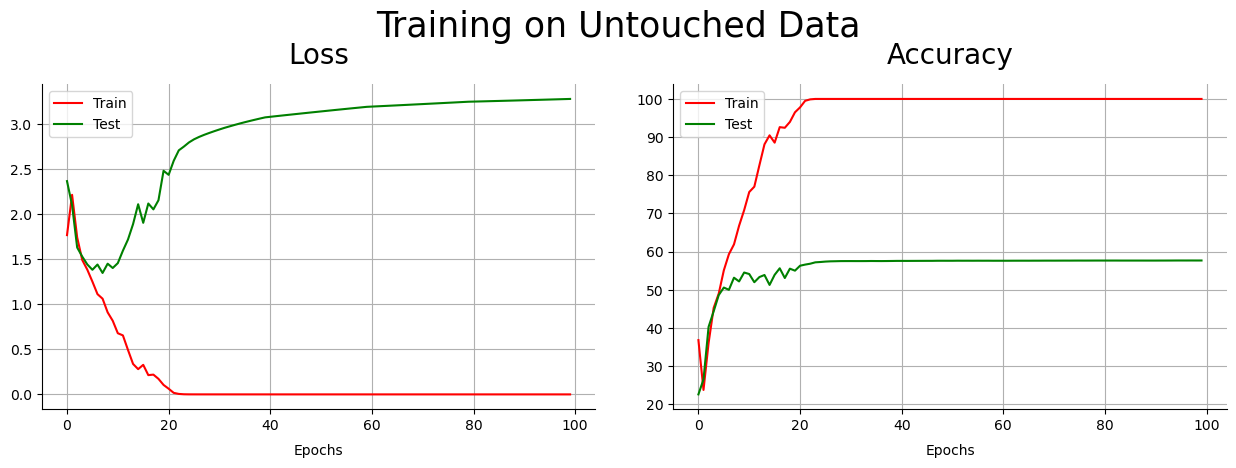

In [21]:
accloss_plots(train_epoch_loss_1, test_epoch_loss_1, train_epoch_accuracy_1, test_epoch_accuracy_1, title="Training on Untouched Data")

### Accuracy of Test and Validation Data:

In [22]:
val_loss_1, val_acc_1 = test_step(data_loader=val_dataloader_untouched,
                                  model=resnet18_model_1,
                                  loss_fn=CE_loss_fn,
                                 )

print(f"\nAccuracy of validation data: {val_acc_1:.2f}%")

   test: 100%|██████████| 80/80 [00:23<00:00,  3.47it/s, test_acc=57.7, test_loss=3.28]


Accuracy of validation data: 57.65%


In [23]:
test_loss_1, test_acc_1 = test_step(data_loader=test_dataloader_untouched,
                                    model=resnet18_model_1,
                                    loss_fn=CE_loss_fn,
                                   )

print(f"\nAccuracy of test data: {test_acc_1:.2f}%")

   test: 100%|██████████| 20/20 [00:09<00:00,  2.09it/s, test_acc=57.7, test_loss=3.3] 


Accuracy of test data: 57.72%


## UMAP on Backbone Output

### backbone:

In [24]:
resnet18_backbone_1 = nn.Sequential(*list(resnet18_model_1.children())[:-1])

### UMAP on Test and Validation Data:

   test: 100%|██████████| 80/80 [00:23<00:00,  3.39it/s]
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


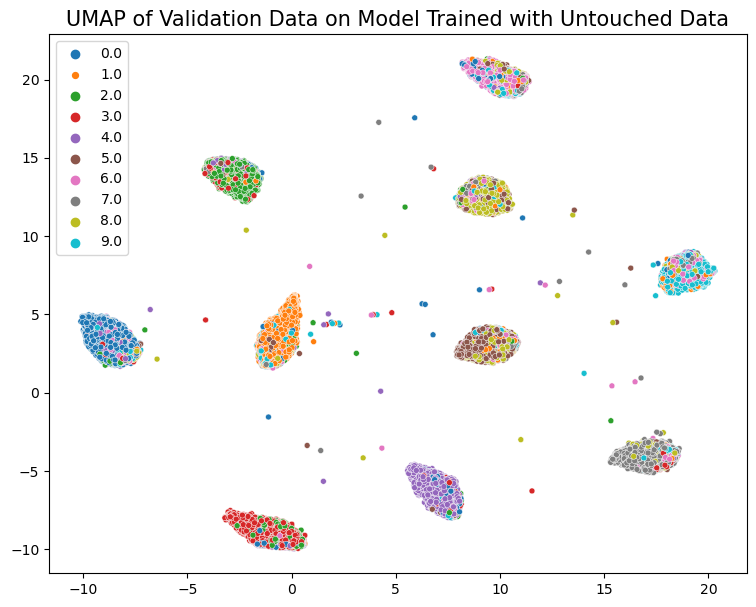

In [38]:
val_reduced_X_1, val_Y_1 = UMAP_DR(model = resnet18_backbone_1,
                                   train_data_loader = train_dataloader_untouched,
                                   test_data_loader = val_dataloader_untouched,
                                   title = "UMAP of Validation Data on Model Trained with Untouched Data"
                                  )

   test: 100%|██████████| 20/20 [00:11<00:00,  1.71it/s]
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


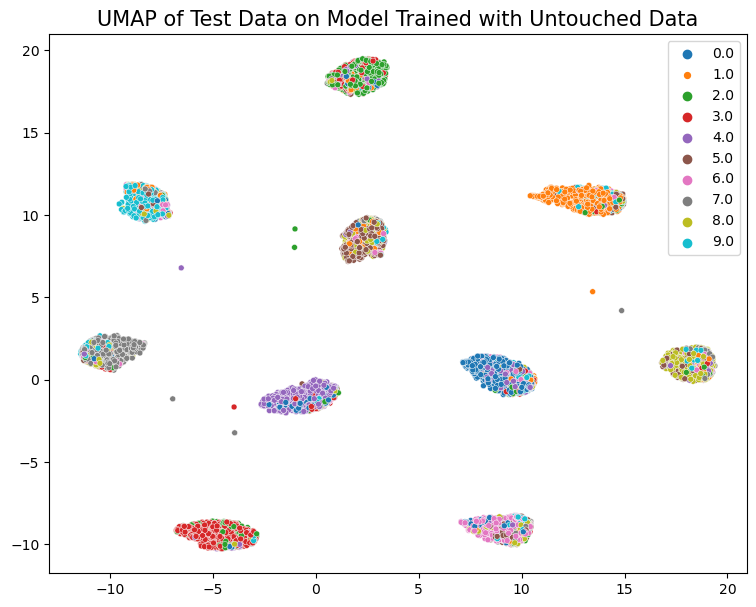

In [37]:
test_reduced_X_1, test_Y_1 = UMAP_DR(model = resnet18_backbone_1,
                                     train_data_loader = train_dataloader_untouched,
                                     test_data_loader = test_dataloader_untouched,
                                     title = "UMAP of Test Data on Model Trained with Untouched Data"
                                    )

---
# Part 3

### Defining Augmentations:

In [39]:
Augmentations = transforms.Compose([transforms.ToTensor(),
                                    transforms.ColorJitter(brightness=.2, contrast=.2, hue=0),
                                    RandomPixelNoise(30, 0.1),
                                    transforms.Normalize(mean=0.5, std=0.5),
                                   ])

### Building Corrupted Dataloaders:

In [40]:
train_dataset_corrupted = Cifar10Dataset(train_imgs, classes, Augmentations)
test_dataset_corrupted = Cifar10Dataset(test_imgs, classes, Augmentations)
val_dataset_corrupted = Cifar10Dataset(val_imgs, classes, Augmentations)

In [41]:
# batchsize = 512

train_dataloader_corrupted = DataLoader(
    dataset = train_dataset_corrupted,
    batch_sampler = BalancedBatchSampler(train_dataset_corrupted, n_classes=10, n_samples=50),
    num_workers = 2,
)

test_dataloader_corrupted = DataLoader(
    dataset = test_dataset_corrupted,
    batch_sampler = BalancedBatchSampler(test_dataset_corrupted, n_classes=10, n_samples=50),
    num_workers = 2,
)

val_dataloader_corrupted = DataLoader(
    dataset = val_dataset_corrupted,
    batch_sampler = BalancedBatchSampler(val_dataset_corrupted, n_classes=10, n_samples=50),
    num_workers = 2,
)

### Sample Corrupted Images:

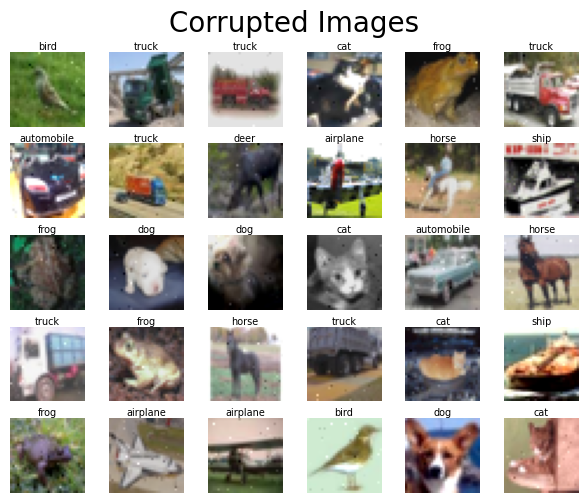

In [42]:
sample_images(dataloader=train_dataloader_corrupted, title="Corrupted Images")

### Accuracy of Corrupted Test and Validation Data:

In [43]:
val_loss_2, val_acc_2 = test_step(data_loader=val_dataloader_corrupted,
                                  model=resnet18_model_1,
                                  loss_fn=CE_loss_fn,
                                  fg_attack=True,
                                 )

print(f"\nAccuracy of validation data: {val_acc_2:.2f}%")

   test: 100%|██████████| 80/80 [00:41<00:00,  1.93it/s, test_acc=21.4, test_loss=13.2]


Accuracy of validation data: 21.40%


In [44]:
test_loss_2, test_acc_2 = test_step(data_loader=test_dataloader_corrupted,
                                    model=resnet18_model_1,
                                    loss_fn=CE_loss_fn,
                                    fg_attack=True,
                                   )

print(f"\nAccuracy of test data: {test_acc_2:.2f}%")

   test: 100%|██████████| 20/20 [00:11<00:00,  1.79it/s, test_acc=21.8, test_loss=13.2]


Accuracy of test data: 21.83%


### UMAP on Corrupted Test & Validation Data:

   test: 100%|██████████| 80/80 [00:40<00:00,  1.96it/s]


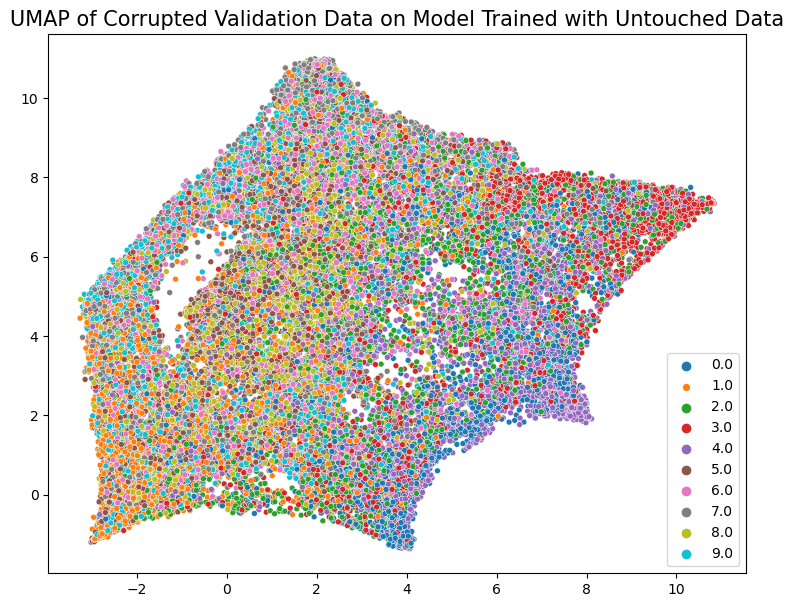

In [45]:
val_reduced_X_2, val_Y_2 = UMAP_DR(model = resnet18_backbone_1,
                                   train_data_loader = train_dataloader_corrupted,
                                   test_data_loader = val_dataloader_corrupted,
                                   fg_attack = True,
                                   title = "UMAP of Corrupted Validation Data on Model Trained with Untouched Data"
                                  )

   test: 100%|██████████| 20/20 [00:10<00:00,  1.90it/s]


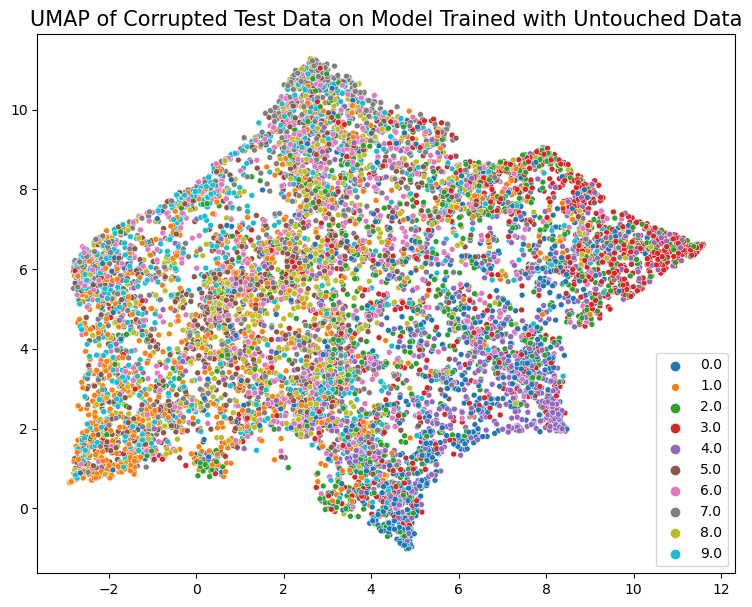

In [46]:
test_reduced_X_2, test_Y_2 = UMAP_DR(model = resnet18_backbone_1,
                                   train_data_loader = train_dataloader_corrupted,
                                   test_data_loader = test_dataloader_corrupted,
                                   fg_attack = True,
                                   title = "UMAP of Corrupted Test Data on Model Trained with Untouched Data"
                                  )

---
# Part 4

### Defining Model (Resnet18):

In [47]:
resnet18_model_2 = torchvision.models.resnet18(weights=None)
resnet18_model_2.fc = nn.Linear(in_features=512, out_features=10, bias=True)

# Optimizer
optimizer_2 = torch.optim.Adam(resnet18_model_2.parameters(), lr = 0.001)
scheduler_2 = torch.optim.lr_scheduler.StepLR(optimizer_2, step_size=20, gamma=0.5)

### Training with Adversarial Examples:

In [48]:
train_epoch_loss_2, train_epoch_accuracy_2, test_epoch_loss_2, test_epoch_accuracy_2 = Train(train_dataloader=train_dataloader_corrupted,
                                                                                             test_dataloader=val_dataloader_corrupted,
                                                                                             model=resnet18_model_2,
                                                                                             loss_fn=CE_loss_fn,
                                                                                             optimizer=optimizer_2,
                                                                                             scheduler=scheduler_2,
                                                                                             epochs=100,
                                                                                             fg_attack=True,
                                                                                            )

EPOCH 1/100 :


   test: 100%|██████████| 80/80 [00:42<00:00,  1.89it/s, test_acc=23.2, test_loss=2.14]


EPOCH 2/100 :


   test: 100%|██████████| 80/80 [00:41<00:00,  1.93it/s, test_acc=25.7, test_loss=1.92]


EPOCH 3/100 :


   test: 100%|██████████| 80/80 [00:40<00:00,  1.96it/s, test_acc=27.3, test_loss=1.9] 


EPOCH 4/100 :


   test: 100%|██████████| 80/80 [00:40<00:00,  1.95it/s, test_acc=27.6, test_loss=1.87]


EPOCH 5/100 :


   test: 100%|██████████| 80/80 [00:40<00:00,  1.97it/s, test_acc=29, test_loss=1.82]  


EPOCH 6/100 :


   test: 100%|██████████| 80/80 [00:40<00:00,  1.98it/s, test_acc=30.1, test_loss=1.79]


EPOCH 7/100 :


   test: 100%|██████████| 80/80 [00:41<00:00,  1.93it/s, test_acc=29, test_loss=1.81]  


EPOCH 8/100 :


   test: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s, test_acc=30.6, test_loss=1.78]


EPOCH 9/100 :


   test: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s, test_acc=29.9, test_loss=1.79]


EPOCH 10/100 :


   test: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s, test_acc=31, test_loss=1.76]  


EPOCH 11/100 :


   test: 100%|██████████| 80/80 [00:40<00:00,  1.97it/s, test_acc=30.6, test_loss=1.77]


EPOCH 12/100 :


   test: 100%|██████████| 80/80 [00:40<00:00,  1.97it/s, test_acc=29.8, test_loss=1.79]


EPOCH 13/100 :


   test: 100%|██████████| 80/80 [00:41<00:00,  1.93it/s, test_acc=30, test_loss=1.78]  


EPOCH 14/100 :


   test: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s, test_acc=30.7, test_loss=1.78]


EPOCH 15/100 :


   test: 100%|██████████| 80/80 [00:41<00:00,  1.92it/s, test_acc=29.8, test_loss=1.79]


EPOCH 16/100 :


   test: 100%|██████████| 80/80 [00:41<00:00,  1.92it/s, test_acc=29.2, test_loss=1.84]


EPOCH 17/100 :


   test: 100%|██████████| 80/80 [00:41<00:00,  1.91it/s, test_acc=28.4, test_loss=1.86]


EPOCH 18/100 :


   test: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s, test_acc=29, test_loss=1.89]  


EPOCH 19/100 :


   test: 100%|██████████| 80/80 [00:40<00:00,  1.96it/s, test_acc=29.2, test_loss=1.88]


EPOCH 20/100 :


   test: 100%|██████████| 80/80 [00:41<00:00,  1.93it/s, test_acc=29.1, test_loss=1.98]


EPOCH 21/100 :


   test: 100%|██████████| 80/80 [00:40<00:00,  1.98it/s, test_acc=28.9, test_loss=1.98]


EPOCH 22/100 :


   test: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s, test_acc=28.1, test_loss=2.07]


EPOCH 23/100 :


   test: 100%|██████████| 80/80 [00:40<00:00,  1.97it/s, test_acc=28.4, test_loss=2.11]


EPOCH 24/100 :


   test: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s, test_acc=28.4, test_loss=2.2] 


EPOCH 25/100 :


   test: 100%|██████████| 80/80 [00:42<00:00,  1.89it/s, test_acc=28.1, test_loss=2.3] 


EPOCH 26/100 :


   test: 100%|██████████| 80/80 [00:41<00:00,  1.92it/s, test_acc=28.4, test_loss=2.42]


EPOCH 27/100 :


   test: 100%|██████████| 80/80 [00:42<00:00,  1.90it/s, test_acc=27.6, test_loss=2.52]


EPOCH 28/100 :


   test: 100%|██████████| 80/80 [00:42<00:00,  1.90it/s, test_acc=28.1, test_loss=2.64]


EPOCH 29/100 :


   test: 100%|██████████| 80/80 [00:41<00:00,  1.91it/s, test_acc=27.2, test_loss=2.79]


EPOCH 30/100 :


   test: 100%|██████████| 80/80 [00:41<00:00,  1.91it/s, test_acc=27.4, test_loss=2.82]


EPOCH 31/100 :


   test: 100%|██████████| 80/80 [00:42<00:00,  1.90it/s, test_acc=27.3, test_loss=2.89]


EPOCH 32/100 :


   test: 100%|██████████| 80/80 [00:41<00:00,  1.91it/s, test_acc=27.3, test_loss=2.93]


EPOCH 33/100 :


   test: 100%|██████████| 80/80 [00:43<00:00,  1.86it/s, test_acc=27.4, test_loss=3.11]


EPOCH 34/100 :


   test: 100%|██████████| 80/80 [00:42<00:00,  1.90it/s, test_acc=27.8, test_loss=3.08]


EPOCH 35/100 :


   test: 100%|██████████| 80/80 [00:42<00:00,  1.87it/s, test_acc=27.5, test_loss=3.2] 


EPOCH 36/100 :


   test: 100%|██████████| 80/80 [00:42<00:00,  1.90it/s, test_acc=27.3, test_loss=3.38]


EPOCH 37/100 :


   test: 100%|██████████| 80/80 [00:42<00:00,  1.89it/s, test_acc=27.2, test_loss=3.46]


EPOCH 38/100 :


   test: 100%|██████████| 80/80 [00:46<00:00,  1.74it/s, test_acc=27.1, test_loss=3.37]


EPOCH 39/100 :


   test: 100%|██████████| 80/80 [00:42<00:00,  1.87it/s, test_acc=27.1, test_loss=3.46]


EPOCH 40/100 :


   test: 100%|██████████| 80/80 [00:42<00:00,  1.89it/s, test_acc=27.1, test_loss=3.66]


EPOCH 41/100 :


   test: 100%|██████████| 80/80 [00:41<00:00,  1.92it/s, test_acc=27.4, test_loss=4]   


EPOCH 42/100 :


   test: 100%|██████████| 80/80 [00:42<00:00,  1.86it/s, test_acc=27.1, test_loss=4.36]


EPOCH 43/100 :


   test: 100%|██████████| 80/80 [00:41<00:00,  1.92it/s, test_acc=27.6, test_loss=4.52]


EPOCH 44/100 :


   test: 100%|██████████| 80/80 [00:41<00:00,  1.93it/s, test_acc=27, test_loss=4.91]  


EPOCH 45/100 :


   test: 100%|██████████| 80/80 [00:41<00:00,  1.91it/s, test_acc=26.9, test_loss=5.02]


EPOCH 46/100 :


   test: 100%|██████████| 80/80 [00:42<00:00,  1.87it/s, test_acc=26.7, test_loss=5.05]


EPOCH 47/100 :


   test: 100%|██████████| 80/80 [00:42<00:00,  1.90it/s, test_acc=26.7, test_loss=5.23]


EPOCH 48/100 :


   test: 100%|██████████| 80/80 [00:42<00:00,  1.88it/s, test_acc=27, test_loss=5.22]  


EPOCH 49/100 :


   test: 100%|██████████| 80/80 [00:42<00:00,  1.88it/s, test_acc=27, test_loss=5.23]  


EPOCH 50/100 :


   test: 100%|██████████| 80/80 [00:43<00:00,  1.85it/s, test_acc=26.9, test_loss=5.45]


EPOCH 51/100 :


   test: 100%|██████████| 80/80 [00:41<00:00,  1.92it/s, test_acc=27.3, test_loss=5.63]


EPOCH 52/100 :


   test: 100%|██████████| 80/80 [00:42<00:00,  1.87it/s, test_acc=27.1, test_loss=5.62]


EPOCH 53/100 :


   test: 100%|██████████| 80/80 [00:40<00:00,  1.96it/s, test_acc=26.7, test_loss=5.56]


EPOCH 54/100 :


   test: 100%|██████████| 80/80 [00:40<00:00,  1.97it/s, test_acc=27.1, test_loss=5.55]


EPOCH 55/100 :


   test: 100%|██████████| 80/80 [00:40<00:00,  2.00it/s, test_acc=26.9, test_loss=5.47]


EPOCH 56/100 :


   test: 100%|██████████| 80/80 [00:39<00:00,  2.01it/s, test_acc=26.6, test_loss=5.62]


EPOCH 57/100 :


   test: 100%|██████████| 80/80 [00:40<00:00,  2.00it/s, test_acc=26.9, test_loss=5.58]


EPOCH 58/100 :


   test: 100%|██████████| 80/80 [00:40<00:00,  1.98it/s, test_acc=27, test_loss=5.89]  


EPOCH 59/100 :


   test: 100%|██████████| 80/80 [00:40<00:00,  1.99it/s, test_acc=26.9, test_loss=6.03]


EPOCH 60/100 :


   test: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s, test_acc=26.7, test_loss=6.08]


EPOCH 61/100 :


   test: 100%|██████████| 80/80 [00:40<00:00,  1.98it/s, test_acc=26.4, test_loss=6.22]


EPOCH 62/100 :


   test: 100%|██████████| 80/80 [00:39<00:00,  2.00it/s, test_acc=26.8, test_loss=6.42]


EPOCH 63/100 :


   test: 100%|██████████| 80/80 [00:40<00:00,  1.97it/s, test_acc=27.2, test_loss=6.67]


EPOCH 64/100 :


   test: 100%|██████████| 80/80 [00:40<00:00,  1.99it/s, test_acc=26.9, test_loss=6.85]


EPOCH 65/100 :


   test: 100%|██████████| 80/80 [00:40<00:00,  1.99it/s, test_acc=27, test_loss=7.01]  


EPOCH 66/100 :


   test: 100%|██████████| 80/80 [00:41<00:00,  1.92it/s, test_acc=27, test_loss=7.04]  


EPOCH 67/100 :


   test: 100%|██████████| 80/80 [00:40<00:00,  1.96it/s, test_acc=27.1, test_loss=7.19]


EPOCH 68/100 :


   test: 100%|██████████| 80/80 [00:41<00:00,  1.93it/s, test_acc=27, test_loss=7.43]  


EPOCH 69/100 :


   test: 100%|██████████| 80/80 [00:42<00:00,  1.90it/s, test_acc=27.3, test_loss=7.51]


EPOCH 70/100 :


   test: 100%|██████████| 80/80 [00:41<00:00,  1.93it/s, test_acc=27.2, test_loss=7.59]


EPOCH 71/100 :


   test: 100%|██████████| 80/80 [00:41<00:00,  1.92it/s, test_acc=27.1, test_loss=7.44]


EPOCH 72/100 :


   test: 100%|██████████| 80/80 [00:42<00:00,  1.88it/s, test_acc=27.5, test_loss=7.61]


EPOCH 73/100 :


   test: 100%|██████████| 80/80 [00:41<00:00,  1.93it/s, test_acc=27, test_loss=7.57]  


EPOCH 74/100 :


   test: 100%|██████████| 80/80 [00:41<00:00,  1.93it/s, test_acc=27.3, test_loss=7.65]


EPOCH 75/100 :


   test: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s, test_acc=27.1, test_loss=7.73]


EPOCH 76/100 :


   test: 100%|██████████| 80/80 [00:40<00:00,  1.98it/s, test_acc=27.2, test_loss=7.83]


EPOCH 77/100 :


   test: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s, test_acc=26.9, test_loss=7.71]


EPOCH 78/100 :


   test: 100%|██████████| 80/80 [00:41<00:00,  1.92it/s, test_acc=26.8, test_loss=7.75]


EPOCH 79/100 :


   test: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s, test_acc=27.1, test_loss=7.83]


EPOCH 80/100 :


   test: 100%|██████████| 80/80 [00:41<00:00,  1.93it/s, test_acc=26.9, test_loss=7.9] 


EPOCH 81/100 :


   test: 100%|██████████| 80/80 [00:41<00:00,  1.93it/s, test_acc=27.3, test_loss=7.94]


EPOCH 82/100 :


   test: 100%|██████████| 80/80 [00:41<00:00,  1.93it/s, test_acc=27.4, test_loss=8.03]


EPOCH 83/100 :


   test: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s, test_acc=27.6, test_loss=8.16]


EPOCH 84/100 :


   test: 100%|██████████| 80/80 [00:41<00:00,  1.92it/s, test_acc=27.3, test_loss=8.23]


EPOCH 85/100 :


   test: 100%|██████████| 80/80 [00:40<00:00,  1.97it/s, test_acc=27.8, test_loss=8.26]


EPOCH 86/100 :


   test: 100%|██████████| 80/80 [00:43<00:00,  1.84it/s, test_acc=27.3, test_loss=8.41]


EPOCH 87/100 :


   test: 100%|██████████| 80/80 [00:41<00:00,  1.92it/s, test_acc=27.5, test_loss=8.58]


EPOCH 88/100 :


   test: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s, test_acc=27.6, test_loss=8.57]


EPOCH 89/100 :


   test: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s, test_acc=27.5, test_loss=8.53]


EPOCH 90/100 :


   test: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s, test_acc=27.2, test_loss=8.74]


EPOCH 91/100 :


   test: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s, test_acc=27.4, test_loss=8.8] 


EPOCH 92/100 :


   test: 100%|██████████| 80/80 [00:44<00:00,  1.78it/s, test_acc=27.7, test_loss=8.82]


EPOCH 93/100 :


   test: 100%|██████████| 80/80 [00:40<00:00,  1.96it/s, test_acc=27.5, test_loss=8.95]


EPOCH 94/100 :


   test: 100%|██████████| 80/80 [00:41<00:00,  1.92it/s, test_acc=27.7, test_loss=8.91]


EPOCH 95/100 :


   test: 100%|██████████| 80/80 [00:41<00:00,  1.93it/s, test_acc=27.7, test_loss=9.21]


EPOCH 96/100 :


   test: 100%|██████████| 80/80 [00:40<00:00,  1.97it/s, test_acc=27.6, test_loss=9.15]


EPOCH 97/100 :


   test: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s, test_acc=27.9, test_loss=9.22]


EPOCH 98/100 :


   test: 100%|██████████| 80/80 [00:40<00:00,  1.97it/s, test_acc=28, test_loss=9.3]   


EPOCH 99/100 :


   test: 100%|██████████| 80/80 [00:39<00:00,  2.01it/s, test_acc=27.6, test_loss=9.41]


EPOCH 100/100 :


   test: 100%|██████████| 80/80 [00:40<00:00,  1.98it/s, test_acc=27.8, test_loss=9.46]



Train time: 5258.001 seconds


### Loss & Acc Plots:

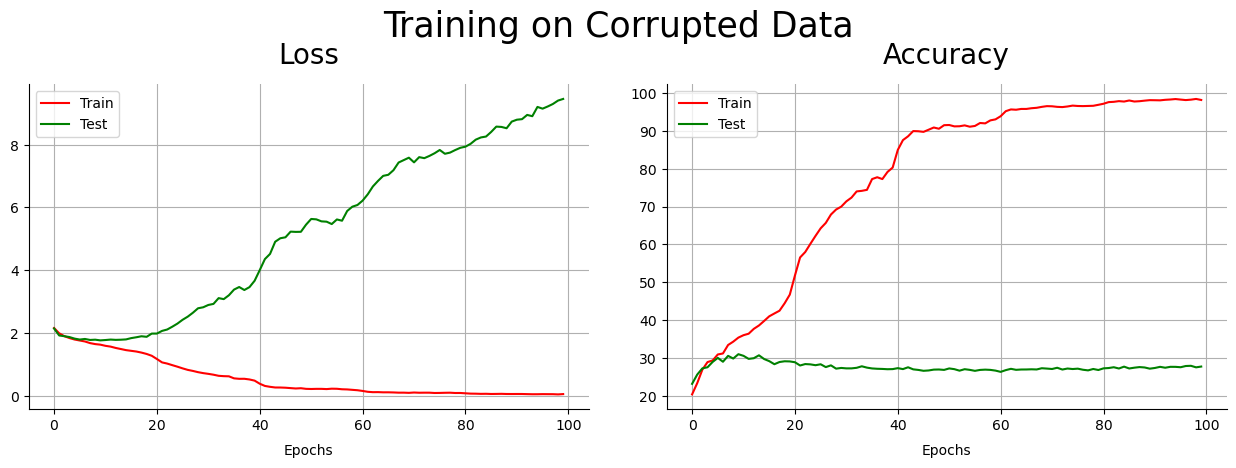

In [49]:
accloss_plots(train_epoch_loss_2, test_epoch_loss_2, train_epoch_accuracy_2, test_epoch_accuracy_2, title="Training on Corrupted Data")

### Accuracy of Trained Model with Adversarial Examples on Corrupted Test and Validation Data:

In [50]:
val_loss_3, val_acc_3 = test_step(data_loader=val_dataloader_untouched,
                                  model=resnet18_model_2,
                                  loss_fn=CE_loss_fn,
                                  fg_attack=True,
                                 )

print(f"\nAccuracy of validation data: {val_acc_3:.2f}%")

   test: 100%|██████████| 80/80 [00:25<00:00,  3.15it/s, test_acc=28.2, test_loss=9.53]


Accuracy of validation data: 28.25%


In [51]:
test_loss_3, test_acc_3 = test_step(data_loader=test_dataloader_untouched,
                                    model=resnet18_model_2,
                                    loss_fn=CE_loss_fn,
                                    fg_attack=True,
                                   )

print(f"\nAccuracy of test data: {test_acc_3:.2f}%")

   test: 100%|██████████| 20/20 [00:10<00:00,  1.88it/s, test_acc=28, test_loss=9.47]  


Accuracy of test data: 27.98%


## UMAP on Backbone Output

### backbone:

In [52]:
resnet18_backbone_2 = nn.Sequential(*list(resnet18_model_2.children())[:-1])

### UMAP of Trained Model with Adversarial Examples on Corrupted Test and Validation Data:

   test: 100%|██████████| 80/80 [00:40<00:00,  2.00it/s]


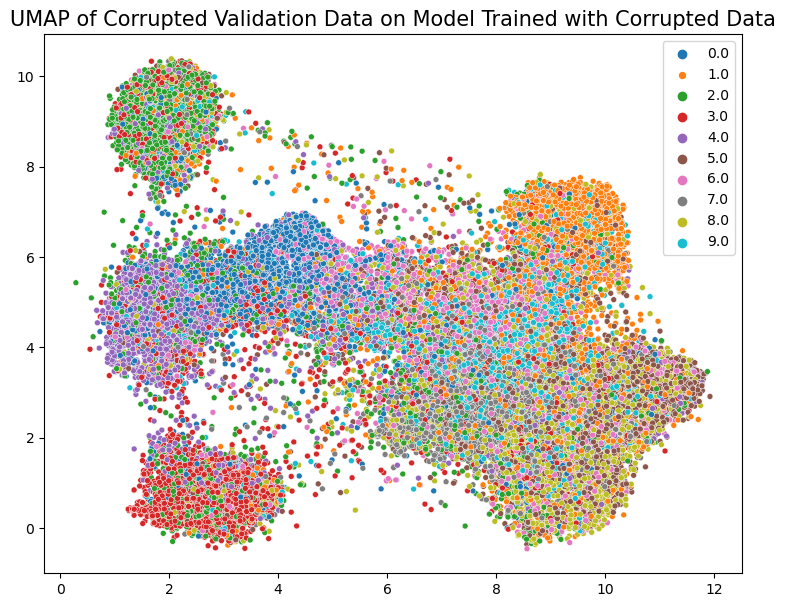

In [53]:
val_reduced_X_3, val_Y_3 = UMAP_DR(model=resnet18_backbone_2,
                                   train_data_loader=train_dataloader_corrupted,
                                   test_data_loader=val_dataloader_corrupted,
                                   fg_attack=True,
                                   title = "UMAP of Corrupted Validation Data on Model Trained with Corrupted Data"
                                  )

   test: 100%|██████████| 20/20 [00:10<00:00,  1.90it/s]


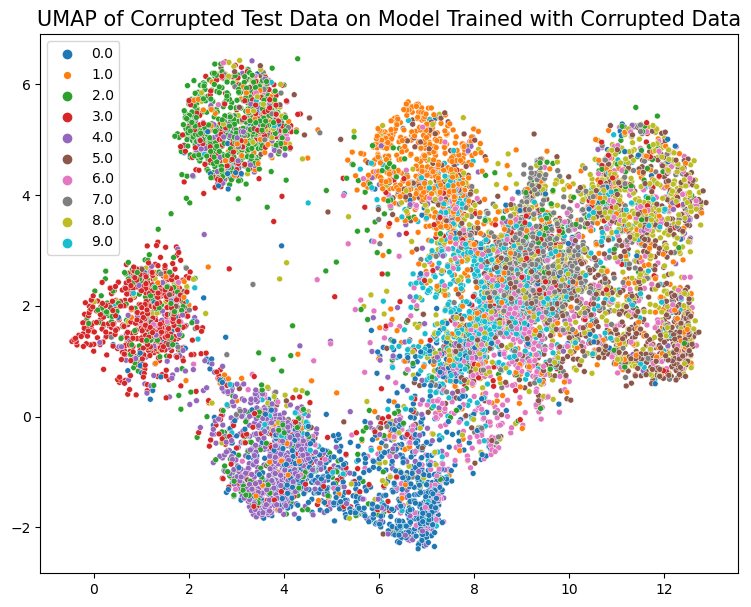

In [54]:
test_reduced_X_3, test_Y_3 = UMAP_DR(model=resnet18_backbone_2,
                                     train_data_loader=train_dataloader_corrupted,
                                     test_data_loader=test_dataloader_corrupted,
                                     fg_attack=True,
                                     title = "UMAP of Corrupted Test Data on Model Trained with Corrupted Data"
                                    )

___
# Part 6:

### Defining Model (Resnet18):

In [55]:
class my_Resnet(nn.Module):
    def __init__(self):
        super(my_Resnet, self).__init__()
        
        self.resnet = torchvision.models.resnet18(weights=None)
        self.resnet.fc = nn.Linear(in_features=512, out_features=64, bias=True)
        
    def forward(self, x: torch.Tensor):
        x = self.resnet(x)
        x = nn.functional.normalize(x)
        return x

    
resnet18_model_3 = my_Resnet()

# Loss Function & Optimizer
AL_loss_fn = losses.AngularLoss(alpha=40)
optimizer_3 = torch.optim.Adam(resnet18_model_3.parameters(), lr = 0.001)
scheduler_3 = torch.optim.lr_scheduler.StepLR(optimizer_3, step_size=20, gamma=0.5)

### Training:

In [56]:
train_epoch_loss_3, train_epoch_accuracy_3, test_epoch_loss_3, test_epoch_accuracy_3 = Train(train_dataloader=train_dataloader_untouched,
                                                                                             test_dataloader=val_dataloader_untouched,
                                                                                             model=resnet18_model_3,
                                                                                             loss_fn=AL_loss_fn,
                                                                                             optimizer=optimizer_3,
                                                                                             scheduler=scheduler_3,
                                                                                             epochs=100)

EPOCH 1/100 :


   test: 100%|██████████| 80/80 [00:24<00:00,  3.24it/s, test_acc=0.19, test_loss=7.4]  


EPOCH 2/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.43it/s, test_acc=1.29, test_loss=6.56]


EPOCH 3/100 :


   test: 100%|██████████| 80/80 [00:24<00:00,  3.32it/s, test_acc=0.965, test_loss=6.16]


EPOCH 4/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.41it/s, test_acc=1.13, test_loss=6.07]


EPOCH 5/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.37it/s, test_acc=0.707, test_loss=6.03]


EPOCH 6/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.47it/s, test_acc=0.83, test_loss=5.95] 


EPOCH 7/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.43it/s, test_acc=0.525, test_loss=5.93]


EPOCH 8/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.46it/s, test_acc=0.437, test_loss=6]   


EPOCH 9/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.47it/s, test_acc=0.765, test_loss=5.96]


EPOCH 10/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.44it/s, test_acc=0.535, test_loss=5.91]


EPOCH 11/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.36it/s, test_acc=0.63, test_loss=5.94] 


EPOCH 12/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.46it/s, test_acc=0.593, test_loss=5.99]


EPOCH 13/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.37it/s, test_acc=0.483, test_loss=5.99]


EPOCH 14/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.46it/s, test_acc=0.628, test_loss=5.99]


EPOCH 15/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.40it/s, test_acc=0.72, test_loss=6.03] 


EPOCH 16/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.41it/s, test_acc=0.365, test_loss=6.05]


EPOCH 17/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.45it/s, test_acc=0.545, test_loss=6.03]


EPOCH 21/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.37it/s, test_acc=0.49, test_loss=6.03] 


EPOCH 22/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.42it/s, test_acc=0.54, test_loss=6.06] 


EPOCH 23/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.36it/s, test_acc=0.467, test_loss=6.1] 


EPOCH 24/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.40it/s, test_acc=0.417, test_loss=6.11]


EPOCH 25/100 :


   test: 100%|██████████| 80/80 [00:24<00:00,  3.32it/s, test_acc=0.6, test_loss=6.18]  


EPOCH 26/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.38it/s, test_acc=0.485, test_loss=6.19]


EPOCH 27/100 :


   test: 100%|██████████| 80/80 [00:24<00:00,  3.30it/s, test_acc=0.588, test_loss=6.16]


EPOCH 28/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.43it/s, test_acc=0.555, test_loss=6.18]


EPOCH 29/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.35it/s, test_acc=0.623, test_loss=6.2] 


EPOCH 30/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.46it/s, test_acc=0.505, test_loss=6.2] 


EPOCH 31/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.38it/s, test_acc=0.567, test_loss=6.22]


EPOCH 32/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.45it/s, test_acc=0.455, test_loss=6.3] 


EPOCH 33/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.36it/s, test_acc=0.473, test_loss=6.22]


EPOCH 34/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.43it/s, test_acc=0.447, test_loss=6.19]


EPOCH 35/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.36it/s, test_acc=0.405, test_loss=6.26]


EPOCH 36/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.38it/s, test_acc=0.585, test_loss=6.26]


EPOCH 37/100 :


   test: 100%|██████████| 80/80 [00:24<00:00,  3.33it/s, test_acc=0.55, test_loss=6.2]  


EPOCH 38/100 :


   test: 100%|██████████| 80/80 [00:24<00:00,  3.23it/s, test_acc=0.535, test_loss=6.28]


EPOCH 39/100 :


   test: 100%|██████████| 80/80 [00:25<00:00,  3.15it/s, test_acc=0.415, test_loss=6.26]


EPOCH 40/100 :


   test: 100%|██████████| 80/80 [00:25<00:00,  3.18it/s, test_acc=0.31, test_loss=6.3]  


EPOCH 41/100 :


   test: 100%|██████████| 80/80 [00:25<00:00,  3.10it/s, test_acc=0.57, test_loss=6.24] 


EPOCH 42/100 :


   test: 100%|██████████| 80/80 [00:26<00:00,  3.04it/s, test_acc=0.522, test_loss=6.25]


EPOCH 43/100 :


   test: 100%|██████████| 80/80 [00:24<00:00,  3.32it/s, test_acc=0.525, test_loss=6.25]


EPOCH 44/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.36it/s, test_acc=0.49, test_loss=6.27] 


EPOCH 45/100 :


   test: 100%|██████████| 80/80 [00:24<00:00,  3.30it/s, test_acc=0.477, test_loss=6.32]


EPOCH 46/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.36it/s, test_acc=0.51, test_loss=6.29] 


EPOCH 47/100 :


   test: 100%|██████████| 80/80 [00:24<00:00,  3.31it/s, test_acc=0.508, test_loss=6.31]


EPOCH 48/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.38it/s, test_acc=0.458, test_loss=6.3] 


EPOCH 49/100 :


   test: 100%|██████████| 80/80 [00:24<00:00,  3.33it/s, test_acc=0.472, test_loss=6.31]


EPOCH 50/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.38it/s, test_acc=0.475, test_loss=6.32]


EPOCH 51/100 :


   test: 100%|██████████| 80/80 [00:25<00:00,  3.14it/s, test_acc=0.475, test_loss=6.32]


EPOCH 52/100 :


   test: 100%|██████████| 80/80 [00:24<00:00,  3.32it/s, test_acc=0.468, test_loss=6.33]


EPOCH 53/100 :


   test: 100%|██████████| 80/80 [00:26<00:00,  2.99it/s, test_acc=0.468, test_loss=6.34]


EPOCH 54/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.35it/s, test_acc=0.462, test_loss=6.34]


EPOCH 55/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.34it/s, test_acc=0.46, test_loss=6.35] 


EPOCH 56/100 :


   test: 100%|██████████| 80/80 [00:24<00:00,  3.28it/s, test_acc=0.465, test_loss=6.35]


EPOCH 57/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.35it/s, test_acc=0.47, test_loss=6.36] 


EPOCH 58/100 :


   test: 100%|██████████| 80/80 [00:24<00:00,  3.29it/s, test_acc=0.467, test_loss=6.36]


EPOCH 59/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.38it/s, test_acc=0.45, test_loss=6.36] 


EPOCH 60/100 :


   test: 100%|██████████| 80/80 [00:24<00:00,  3.20it/s, test_acc=0.443, test_loss=6.37]


EPOCH 61/100 :


   test: 100%|██████████| 80/80 [00:24<00:00,  3.20it/s, test_acc=0.442, test_loss=6.37]


EPOCH 62/100 :


   test: 100%|██████████| 80/80 [00:24<00:00,  3.20it/s, test_acc=0.445, test_loss=6.37]


EPOCH 63/100 :


   test: 100%|██████████| 80/80 [00:24<00:00,  3.25it/s, test_acc=0.442, test_loss=6.37]


EPOCH 64/100 :


   test: 100%|██████████| 80/80 [00:24<00:00,  3.23it/s, test_acc=0.44, test_loss=6.37] 


EPOCH 65/100 :


   test: 100%|██████████| 80/80 [00:24<00:00,  3.24it/s, test_acc=0.442, test_loss=6.37]


EPOCH 66/100 :


   test: 100%|██████████| 80/80 [00:24<00:00,  3.21it/s, test_acc=0.435, test_loss=6.38]


EPOCH 67/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.36it/s, test_acc=0.435, test_loss=6.38]


EPOCH 68/100 :


   test: 100%|██████████| 80/80 [00:24<00:00,  3.27it/s, test_acc=0.435, test_loss=6.38]


EPOCH 69/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.38it/s, test_acc=0.435, test_loss=6.38]


EPOCH 70/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.37it/s, test_acc=0.44, test_loss=6.38] 


EPOCH 71/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.42it/s, test_acc=0.443, test_loss=6.38]


EPOCH 72/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.37it/s, test_acc=0.44, test_loss=6.38] 


EPOCH 73/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.42it/s, test_acc=0.435, test_loss=6.39]


EPOCH 74/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.37it/s, test_acc=0.435, test_loss=6.39]


EPOCH 75/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.36it/s, test_acc=0.437, test_loss=6.39]


EPOCH 76/100 :


   test: 100%|██████████| 80/80 [00:25<00:00,  3.20it/s, test_acc=0.438, test_loss=6.39]


EPOCH 77/100 :


   test: 100%|██████████| 80/80 [00:26<00:00,  3.01it/s, test_acc=0.437, test_loss=6.39]


EPOCH 78/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.36it/s, test_acc=0.432, test_loss=6.39]


EPOCH 79/100 :


   test: 100%|██████████| 80/80 [00:25<00:00,  3.19it/s, test_acc=0.432, test_loss=6.39]


EPOCH 80/100 :


   test: 100%|██████████| 80/80 [00:24<00:00,  3.29it/s, test_acc=0.435, test_loss=6.39]


EPOCH 81/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.38it/s, test_acc=0.422, test_loss=6.4] 


EPOCH 82/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.35it/s, test_acc=0.415, test_loss=6.4] 


EPOCH 83/100 :


   test: 100%|██████████| 80/80 [00:24<00:00,  3.32it/s, test_acc=0.415, test_loss=6.4] 


EPOCH 84/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.34it/s, test_acc=0.415, test_loss=6.4] 


EPOCH 85/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.36it/s, test_acc=0.407, test_loss=6.4] 


EPOCH 86/100 :


   test: 100%|██████████| 80/80 [00:24<00:00,  3.25it/s, test_acc=0.417, test_loss=6.4] 


EPOCH 87/100 :


   test: 100%|██████████| 80/80 [00:24<00:00,  3.21it/s, test_acc=0.42, test_loss=6.4]  


EPOCH 88/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.34it/s, test_acc=0.417, test_loss=6.4] 


EPOCH 89/100 :


   test: 100%|██████████| 80/80 [00:24<00:00,  3.24it/s, test_acc=0.417, test_loss=6.4] 


EPOCH 90/100 :


   test: 100%|██████████| 80/80 [00:24<00:00,  3.32it/s, test_acc=0.417, test_loss=6.4] 


EPOCH 91/100 :


   test: 100%|██████████| 80/80 [00:24<00:00,  3.31it/s, test_acc=0.415, test_loss=6.4] 


EPOCH 92/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.35it/s, test_acc=0.442, test_loss=6.4] 


EPOCH 93/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.36it/s, test_acc=0.432, test_loss=6.4] 


EPOCH 94/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.39it/s, test_acc=0.435, test_loss=6.4] 


EPOCH 95/100 :


   test: 100%|██████████| 80/80 [00:24<00:00,  3.33it/s, test_acc=0.435, test_loss=6.4] 


EPOCH 96/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.37it/s, test_acc=0.435, test_loss=6.4] 


EPOCH 97/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.41it/s, test_acc=0.435, test_loss=6.4] 


EPOCH 98/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.39it/s, test_acc=0.435, test_loss=6.4] 


EPOCH 99/100 :


   test: 100%|██████████| 80/80 [00:23<00:00,  3.40it/s, test_acc=0.44, test_loss=6.4]  


EPOCH 100/100 :


   test: 100%|██████████| 80/80 [00:24<00:00,  3.27it/s, test_acc=0.437, test_loss=6.41]



Train time: 3066.999 seconds


### Loss & Acc Plots:

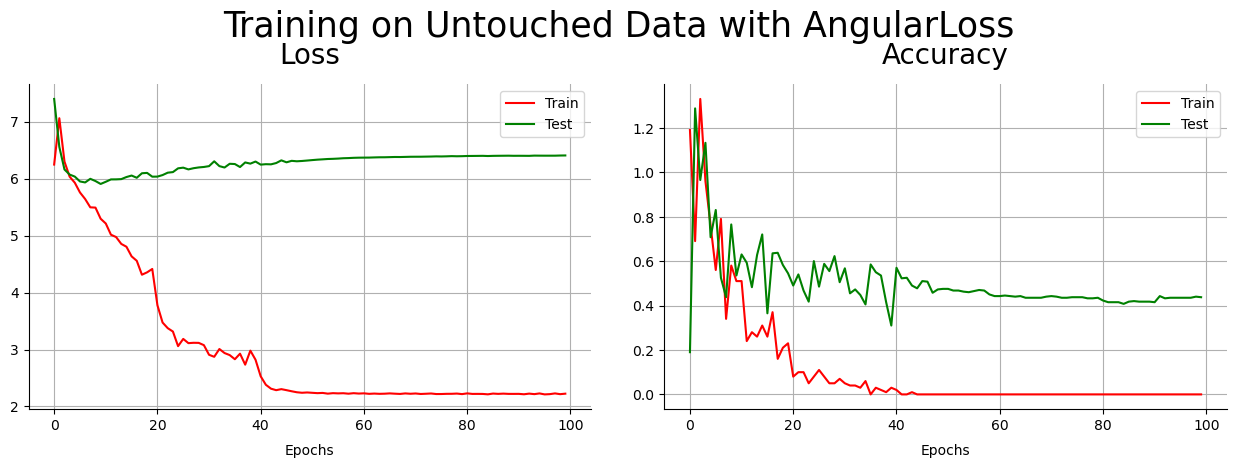

In [57]:
accloss_plots(train_epoch_loss_3, test_epoch_loss_3, train_epoch_accuracy_3, test_epoch_accuracy_3, 
              title="Training on Untouched Data with AngularLoss")

### Accuracy of Corrupted Test and Validation Data:

In [58]:
val_acc_4 = accuracy_calc_using_KNN(model=resnet18_model_3,
                                    train_data_loader=train_dataloader_corrupted,
                                    test_data_loader=val_dataloader_corrupted,
                                    fg_attack=True,)

print(f"\nAccuracy of validation data: {val_acc_4*100:.2f}%")

   test: 100%|██████████| 80/80 [00:41<00:00,  1.93it/s]



Accuracy of validation data: 44.20%


In [59]:
test_acc_4 = accuracy_calc_using_KNN(model=resnet18_model_3,
                                     train_data_loader=train_dataloader_corrupted,
                                     test_data_loader=test_dataloader_corrupted,
                                     fg_attack=True,)

print(f"\nAccuracy of validation data: {test_acc_4*100:.2f}%")

   test: 100%|██████████| 20/20 [00:14<00:00,  1.34it/s]



Accuracy of validation data: 44.87%


### UMAP of Trained Model with Adversarial Examples on Corrupted Test and Validation Data:

   test: 100%|██████████| 80/80 [00:50<00:00,  1.60it/s]


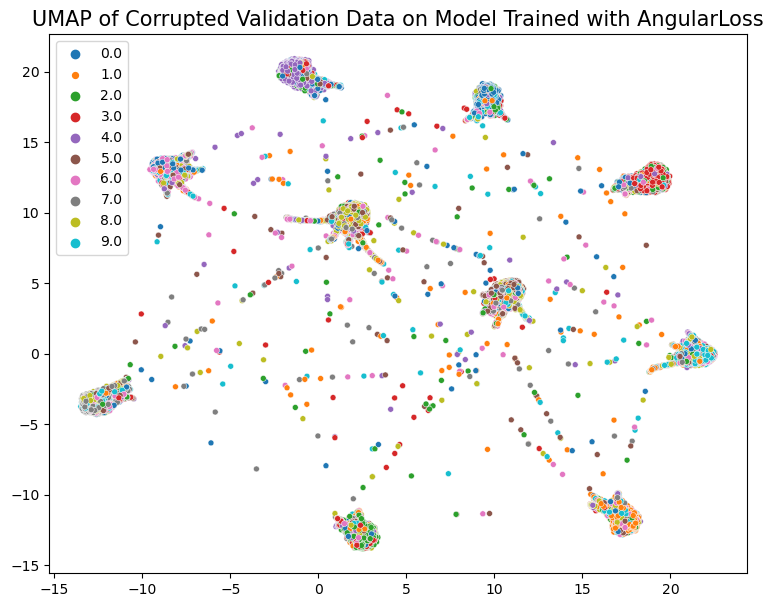

In [65]:
val_reduced_X_4, val_Y_4 = UMAP_DR(model=resnet18_model_3,
                                   train_data_loader=train_dataloader_corrupted,
                                   test_data_loader=val_dataloader_corrupted,
                                   fg_attack=True,
                                   title = "UMAP of Corrupted Validation Data on Model Trained with AngularLoss"
                                  )

   test: 100%|██████████| 20/20 [00:12<00:00,  1.59it/s]


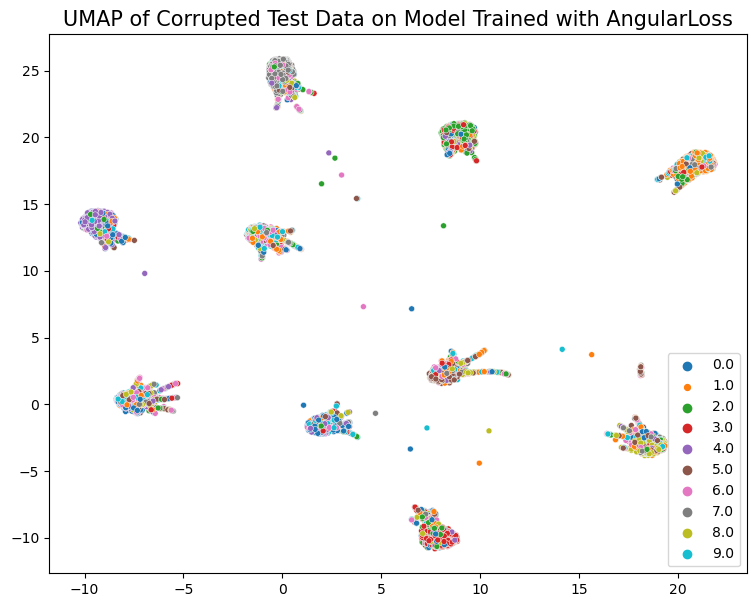

In [66]:
test_reduced_X_4, test_Y_4 = UMAP_DR(model=resnet18_model_3,
                                     train_data_loader=train_dataloader_corrupted,
                                     test_data_loader=test_dataloader_corrupted,
                                     fg_attack=True,
                                     title = "UMAP of Corrupted Test Data on Model Trained with AngularLoss"
                                    )

---

<div align=center lang="fa"><font face="Tahoma" size="5" color=#c4c4c4>End</font></div>

---